In [2]:
import itertools
import pandas as pd
import numpy as np
import re
import os
import torch
from tqdm import tqdm

# Drawing the embeddings
import matplotlib.pyplot as plt

# Deep learning: 
from keras.models import Input, Model
from keras.layers import Dense

from scipy import sparse

import tensorflow as tf

# Custom functions
from utility import text_preprocessing, create_unique_word_dict

In [16]:
# Reading the text from the data folder
# texts = pd.read_csv('input/sample.csv')
texts = pd.read_csv('../data/train_final.csv')
texts = [x for x in texts['text']]
texts = texts[0:10]

In [17]:
# Defining the window for context
window = 2

# Creating a placeholder for the scanning of the word list
word_lists = []
all_text = []

for text in texts:

    # Cleaning the text
    text = text_preprocessing(text)

    # Appending to the all text list
    all_text += text 

    # Creating a context dictionary
    for i, word in enumerate(text):
        for w in range(window):
            # Getting the context that is ahead by *window* words
            if i + 1 + w < len(text): 
                word_lists.append([word] + [text[(i + 1 + w)]])
            # Getting the context that is behind by *window* words    
            if i - w - 1 >= 0:
                word_lists.append([word] + [text[(i - w - 1)]])

unique_word_dict = create_unique_word_dict(all_text)

In [18]:
# print(texts)
# print(word_lists)

In [19]:
# Defining the number of features (unique words)
n_words = len(unique_word_dict)
print(n_words)

# Getting all the unique words 
words = list(unique_word_dict.keys())
print(words)

64
['all', 'alone', 'already', 'are', 'baby', 'became', 'best', 'boss', 'both', 'bought', 'bullying', 'cooler', 'coos', 'couldn`t', 'diego', 'earth', 'feedings', 'for', 'forum', 'fun', 'going', 'have', 'he', 'hehe', 'here', 'high', 'httpwwwdothebouncycomsmf', 'i', 'i`d', 'if', 'interview', 'journey', 'just', 'leave', 'me', 'miss', 'my', 'of', 'on', 'plugging', 'possible', 'put', 'rangers', 'releases', 'responded', 'sad', 'san', 'shameless', 'smiles', 'some', 'sons', 'sooo', 'soooo', 'that', 'them', 'they', 'u', 'we', 'were', 'what', 'when', 'why', 'wow', 'you']


In [20]:
# Creating the X and Y matrices using one hot encoding
X = []
Y = []

for i, word_list in tqdm(enumerate(word_lists)):
    # Getting the indices
    main_word_index = unique_word_dict.get(word_list[0])
    context_word_index = unique_word_dict.get(word_list[1])

    # Creating the placeholders   
    X_row = np.zeros(n_words, dtype="uint8")
    Y_row = np.zeros(n_words, dtype="uint8")

    # One hot encoding the main word
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words 
    Y_row[context_word_index] = 1

    # Appending to the main matrices
    X.append(X_row)
    Y.append(Y_row)

# Converting the matrices into a sparse format because the vast majority of the data are 0s

X = np.asarray(X)
Y = np.asarray(Y)

220it [00:00, 110086.72it/s]


In [25]:
# Defining the size of the embedding
embed_size = 2

# Defining the neural network
inp = Input(shape=(X.shape[1],))
x = Dense(units=embed_size, activation='linear')(inp)
x = Dense(units=Y.shape[1], activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

# Optimizing the network weights
model.fit(
    x=X, 
    y=Y, 
    batch_size=256,
    epochs=1000,
    verbose=0
    )

In [26]:
# Obtaining the weights from the neural network. 
# These are the so called word embeddings

# The input layer 
weights = model.get_weights()[0]

# Creating a dictionary to store the embeddings in. The key is a unique word and 
# the value is the numeric vector
embedding_dict = {}
for word in words: 
    embedding_dict.update({
        word: weights[unique_word_dict.get(word)]
        })
    

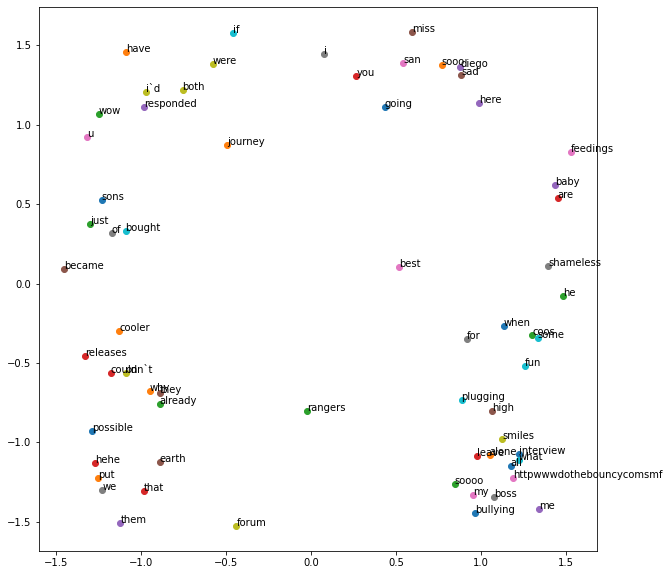

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for word in list(unique_word_dict.keys()):
  coord = embedding_dict.get(word)
  plt.scatter(coord[0], coord[1])
  plt.annotate(word, (coord[0], coord[1]))

In [28]:
print(embedding_dict)

{'all': array([ 1.1749117, -1.1505288], dtype=float32), 'alone': array([ 1.0521108, -1.0806926], dtype=float32), 'already': array([-0.8917223, -0.7608124], dtype=float32), 'are': array([1.4524832, 0.5410862], dtype=float32), 'baby': array([1.4354646, 0.6206662], dtype=float32), 'became': array([-1.4544277 ,  0.09466603], dtype=float32), 'best': array([0.5177354 , 0.10374203], dtype=float32), 'boss': array([ 1.0773891, -1.3453801], dtype=float32), 'both': array([-0.75651085,  1.2195022 ], dtype=float32), 'bought': array([-1.0918717 ,  0.32863757], dtype=float32), 'bullying': array([ 0.96536034, -1.4430544 ], dtype=float32), 'cooler': array([-1.1278144, -0.2969262], dtype=float32), 'coos': array([ 1.302868  , -0.32292557], dtype=float32), 'couldn`t': array([-1.1794069 , -0.56490564], dtype=float32), 'diego': array([0.87810874, 1.3628546 ], dtype=float32), 'earth': array([-0.8900742, -1.122395 ], dtype=float32), 'feedings': array([1.5309952 , 0.82784545], dtype=float32), 'for': array([ 0.

In [ ]:
# Activation function
